# 12-01: Diffusion Speed of Random Walks in Networks

*January 25 2023*  

In this first practice session, we experimentally study the speed of random walk diffusion in different network topologies and validate the analytical prediction based on the second-largest eigenvalue of the transition matrix.

In [1]:
import pathpy as pp
import numpy as np
from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('default')
sns.set_style("whitegrid")
    
from numpy import linalg as npl
import scipy as sp

### Total Variation Distance

To calculate diffusion speed, we first write a function that computes the total variation distance between two stochastic vectors $\pi$ and $\pi'$ as defined in lecture 10.

In [3]:
def tvd(p1, p2):
    assert len(p1) == len(p2)
    tvd = 0
    for i in range(len(p1)):
        tvd +=abs(p1[i] - p2[i])
    return tvd/2

The following helper function returns the total variation distances between the stationary distribution $\pi$ and the visitation probability $\pi^s$ for $s=0, \ldots, t$ steps of a random walk process. We have used the same function in the last practice session of the previous week.

In [4]:
def compute_tvd(network, t, epsilon=0.005):

    t_min = np.inf
    rw = pp.processes.RandomWalk(network)
    T = rw.transition_matrix.todense()
    
    # We use a **right-stochastic matrix**, so what we want to
    # compute is the **left** eigenvectors (see lecture L08)
    eigenvalues, eigenvectors = sp.linalg.eig(T, left=True, right=False)
    
    # Here we take the **leading eigenvector**, i.e. the eigenvector
    # corresponding to the **largest eigenvalue** of one
    # numpy.argsort returns an array of indices that would sort an array
    # note the multi-dimensional slicing :,x, which returns all entries 
    # in column x
    pi = eigenvectors[:,np.argsort(-eigenvalues)][:,0]
    
    # We make sure that the eigenvector is normalised
    pi = pi/sum(pi)

    # We set the initial distribution
    initial_dist = np.array([0]*network.number_of_nodes())
    initial_dist[0] = 1

    # We calculate the total variation dist after each step
    tvds = []
    for s in range(t):
        x = np.ravel(np.dot(initial_dist, np.linalg.matrix_power(T, s)))
        d = tvd(pi,x)
        if d <= epsilon and t_min > s:
            t_min = s
        tvds.append(d)
    return tvds, t_min

We use the function above to calculate and plot the evolution of the total variation distance for the undirected example network.

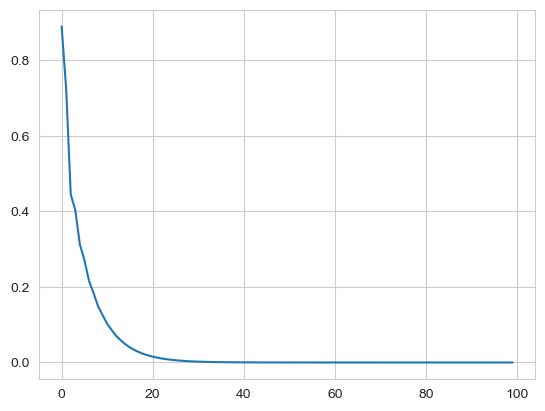

In [6]:
n = pp.Network(directed=False)
n.add_edge('a', 'b')
n.add_edge('b', 'c')
n.add_edge('a', 'c')
n.add_edge('b', 'd')
n.add_edge('d', 'f')
n.add_edge('d', 'g')
n.add_edge('d', 'e')
n.add_edge('e', 'f')
n.add_edge('f', 'g')
n.plot(edge_color='gray')

d, tmin = compute_tvd(n, 100, epsilon=0.05)
plt.plot(np.arange(100), d);

Apart from the evolution of total variation distance over time, the function also returns the smallest time $t_min$ such that the total variation distance is smaller than a given threshold $\epsilon$ for all $t>t_{min}$. Technically, in the function above, we just compute the *first* time that the total variation distance falls below the threshold, i.e. we additionally make a monotonicity assumption.

In [7]:
print('t_min =', tmin)

t_min = 14


This is the quantity that we studied analytically based on the eigendecomposition of the transition matrix. To test how accurate this prediction os, we write a function that calculates the second-largest eigenvalue $\lambda_2$.

In [8]:
def lambda_2(network):
    rw = pp.processes.RandomWalk(network)
    T = rw.transition_matrix.todense()
    eigenvalues, eigenvectors = sp.linalg.eig(T, left=True, right=False)
    x = eigenvalues[np.argsort(-eigenvalues)]
    return np.abs(x[1])

We can use this to derive a prediction based on the result from lecture L12, slide 6. For a total variation distance of $\epsilon=0.05$ we obtain the following lower bound for the minimum number of steps until the total variation distance falls below $\epsilon$:

In [9]:
print('prediction =', np.log(0.05)/np.log(lambda_2(n)))

prediction = 15.780738151107203


The analytical prediction is close to our experimental finding, even though our result was just an approximation that (i) neglected the contribution of the other eigenvalues (see slide 5) and the influence of the specific initial distribution captured by the vector $\alpha$ and the second-largest eigenvector.

## Network Topology and Diffusion Speed

Using code from previous practice sessions or corresponding `pathpy` functions, we can test our analytical prediction in six different random networks:

   1. an Erdös-Renyi network with $n=200$ nodes and $m=400$ links
   2. an Erdös-Renyi network with $n=200$ nodes and $m=600$ links
   3. a modular network consisting of two $5$-regular random networks with $100$ nodes each, which are joined together by crossing the endpoints of two arbitrary chosen links
   4. a scale-free network with $200$ nodes and exponent $\gamma=2.7$
   5. a Watts-Strogatz ring lattice with the parameters $n=200$, $m=5$ and rewiring probability $p=0$
   6. a Watts-Strogatz small-world network with the parameters $n=200$, $m=5$ and rewiring probability $p=0.05$

For each of the six networks we use the function from above to compute the evolution of total variation distance $\delta(\pi^{(t)}, \pi)$ for $t \in \left[0, 500\right]$ where $\pi$ is the stationary distribution. We further calculate $t_{min}$ for a given value of epsilon and compare the result to our analytical prediction.

### Experiment 1: Erdös-Renyi network with 200 nodes and 400 links

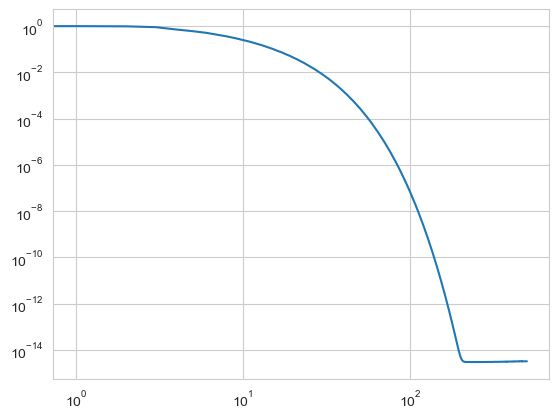

In [10]:
er_1 = pp.generators.random_graphs.ER_nm(n=200, m=400)
er_1 = pp.algorithms.components.largest_connected_component(er_1)

d, tmin = compute_tvd(er_1, 500, epsilon=0.005)

plt.clf()
plt.loglog(np.arange(500), d)
plt.show()

Let us evaluate the experimental diffusion speed as well as the analytical prediction for $\epsilon=0.005$:

In [11]:
print('t_min =', tmin)
print('prediction =', np.abs(np.log(0.005)/np.log(lambda_2(er_1))))

t_min = 33
prediction = 27.74780781604179


### Experiment 2: Erdös-Renyi network with 200 nodes and 600 links

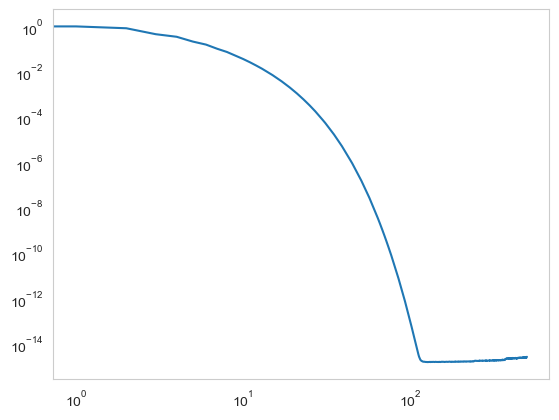

In [12]:
er_2 = pp.generators.random_graphs.ER_nm(n=200, m=600)
er_2 = pp.algorithms.components.largest_connected_component(er_2)

d, tmin = compute_tvd(er_2, 500, epsilon=0.005)

plt.clf()
plt.loglog(np.arange(500), d)
plt.show()

In [13]:
print('t_min =', tmin)
print('prediction =', np.abs(np.log(0.005)/np.log(lambda_2(er_2))))

t_min = 16
prediction = 18.209419403126372


### Experiment 3: Modular network consisting of two 5-regular random networks with a total of 200 nodes

In [15]:
regular_1 = pp.generators.random_graphs.Molloy_Reed([5]*100, node_uids=[str(i) for i in range(100)])
regular_2 = pp.generators.random_graphs.Molloy_Reed([5]*100, node_uids=[str(i) for i in range(100,200)])
modular = regular_1 + regular_2

e1 = list(modular.edges)[1]
e2 = list(modular.edges)[400]

modular.remove_edge(e1.v, e1.w)
modular.remove_edge(e2.v, e2.w)
modular.add_edge(e1.v, e2.w)
modular.add_edge(e2.v, e1.w)

modular.plot(edge_color='gray')

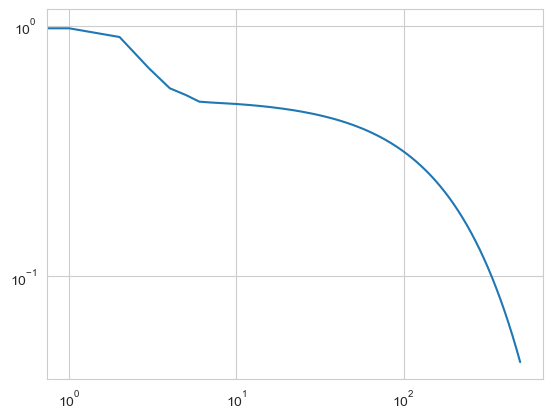

In [16]:
d, tmin = compute_tvd(modular, 500, epsilon=0.005)

plt.clf()
plt.loglog(range(500), d)
plt.show()

In [17]:
print('t_min =', tmin)
print('prediction =', np.abs(np.log(0.005)/np.log(lambda_2(modular))))

t_min = inf
prediction = 1092.2386911692388


Apparantly, a simulation of 500 steps was not enough time for the total variation distance to fall below the given threshold. This is actually due to the bottleneck in the network, which slows down the diffusion process, i.e. you can imagine this bottleneck working similar to an "insulator" that limits the diffusion between the two clusters in the network. Luckily, the analytical prediction tells us how many steps we expect to be required, so we can repeat the simulation to validate this.

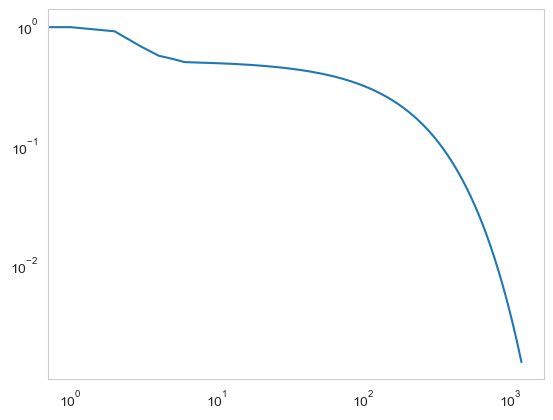

In [18]:
d, tmin = compute_tvd(modular, 1200, epsilon=0.005)

plt.clf()
plt.loglog(range(1200), d)
plt.show()

In [47]:
print('t_min =', tmin)

t_min = 931


### Experiment 4: A scale-free network with power law exponent 2.7 and 200 nodes

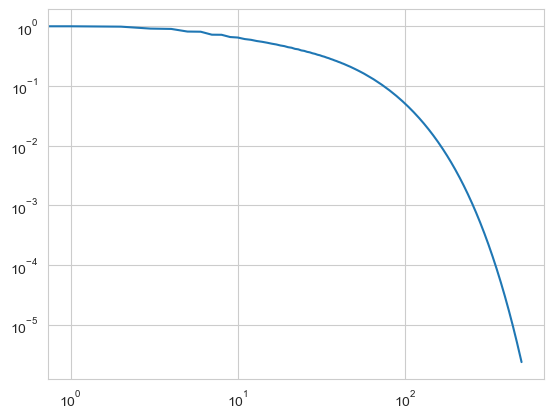

In [21]:
degrees_zipf = [1]
while not pp.generators.random_graphs.is_graphic_Erdos_Gallai(degrees_zipf):
    degrees_zipf = [int(x) for x in np.random.zipf(2.7, 200)]

sf = pp.generators.random_graphs.Molloy_Reed(degrees_zipf)
sf = pp.algorithms.components.largest_connected_component(sf)

d, tmin = compute_tvd(sf, 500)

plt.clf()
plt.loglog(range(500), d)
plt.show()

In [22]:
print('t_min =', tmin)
print('prediction =', np.abs(np.log(0.005)/np.log(lambda_2(sf))))

t_min = 191
prediction = 138.79918608118336


### Experiment 5: A Watts-Strogatz ring lattice with n=200, m=5 and p=0. 

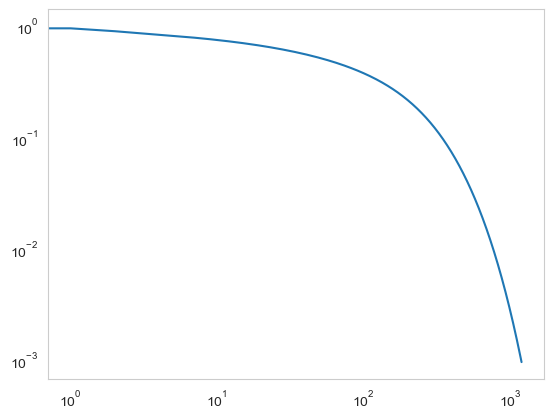

In [23]:
ring = pp.generators.random_graphs.Watts_Strogatz(n = 200, s = 5, p = 0)

d, tmin = compute_tvd(ring, 1200)

plt.clf()
plt.loglog(range(1200), d)
plt.show()

In [24]:
print('t_min =', tmin)
print('prediction =', np.abs(np.log(0.005)/np.log(lambda_2(ring))))

t_min = 892
prediction = 974.8362834946577


### Network 6: A Watts-Strogatz small-world network with n = 200, m=5 and p = 0.05

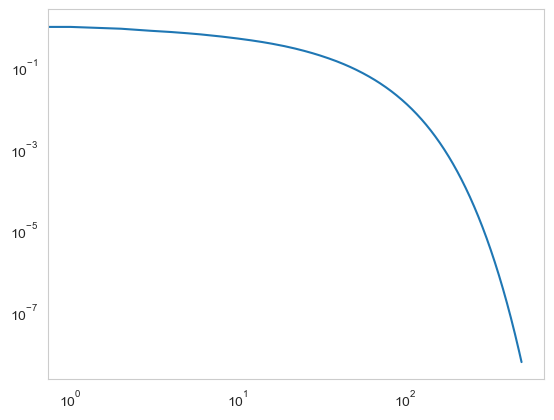

In [25]:
ws = pp.generators.random_graphs.Watts_Strogatz(n = 200, s = 5, p = 0.05)

d, tmin = compute_tvd(ws, 500)

plt.clf()
plt.loglog(range(500), d)
plt.show()

In [26]:
print('t_min =', tmin)
print('prediction =', np.abs(np.log(0.005)/np.log(lambda_2(ws))))

t_min = 127
prediction = 144.18547803774888


### Interpretation of results

We make the following observations: 

1. In a random network, the network with more links (quite expectedly) leads to faster diffusion than the network with fewer links. Moreover, the random network with 600 links gives rise to the **fastest diffusion**, across the studied network topologies.  
2. In the network with 200 nodes and two modules, diffusion is orders of magnitude (!) slower than in a random network.  
3. In the network with two modules, we see an interesting plateau in the evolution of the total variation distance, which is related to the presence of the two communities.  
4. In the scale-free network, diffusion is omuch slower than in random Erdös-Rényi networks.  
5. In the ring topology ($p=0$), **diffusion is the slowest (comparable to the modular network)**.  
6. Randomly rewiring $5 \%$ of the links increases diffusion speed by a factor of ten.

### Final experiment: Fully connected network


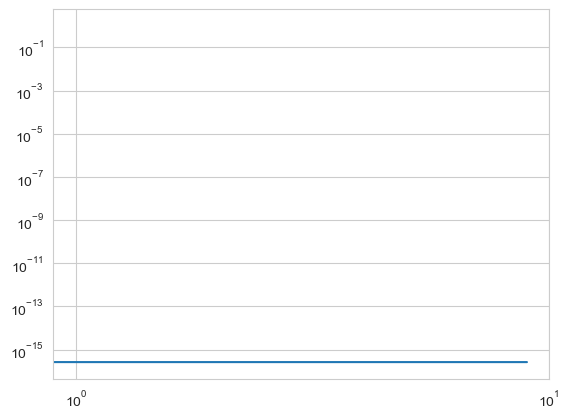

In [27]:
full = pp.generators.random_graphs.ER_np(n=50, p=1, loops=True)

d, tmin = compute_tvd(full, 10)
plt.clf()
plt.loglog(range(10), d)
plt.show()

In [28]:
print('t_min =', tmin)
print('prediction =', np.abs(np.log(0.005)/np.log(lambda_2(full))))
print(lambda_2(full))

t_min = 1
prediction = 0.0
0.0


C:\Users\INGOSC~1\AppData\Local\Temp/ipykernel_31528/1032835834.py:2: RuntimeWarning: divide by zero encountered in log
  print('prediction =', np.abs(np.log(0.005)/np.log(lambda_2(full))))
